# Notebook 7 — Solutions: Numerical Methods & Scientific Computing

Worked solutions for the exercises in Notebook 7.

## Exercise 1 — Floating-point experiments
**Tasks:**
1) Compare eps for float32 vs float64.
2) Experiment with `(a + delta) - a` across magnitudes.

In [1]:
import numpy as np
print('eps float64:', np.finfo(np.float64).eps)
print('eps float32:', np.finfo(np.float32).eps)

def delta_test(a_vals, deltas):
    rows = []
    for a in a_vals:
        for d in deltas:
            observed = (a + d) - a
            rows.append((a, d, observed))
    return rows

a_vals = [1e0, 1e4, 1e8, 1e12, 1e16]
deltas = [1.0, 1e-4, 1e-8, 1e-12]
rows = delta_test(a_vals, deltas)
print('\n(a, delta, (a+delta)-a):')
for r in rows:
    print(r)

eps float64: 2.220446049250313e-16
eps float32: 1.1920929e-07

(a, delta, (a+delta)-a):
(1.0, 1.0, 1.0)
(1.0, 0.0001, 9.999999999998899e-05)
(1.0, 1e-08, 9.99999993922529e-09)
(1.0, 1e-12, 1.000088900582341e-12)
(10000.0, 1.0, 1.0)
(10000.0, 0.0001, 9.999999929277692e-05)
(10000.0, 1e-08, 1.0000803740695119e-08)
(10000.0, 1e-12, 1.8189894035458565e-12)
(100000000.0, 1.0, 1.0)
(100000000.0, 0.0001, 0.00010000169277191162)
(100000000.0, 1e-08, 1.4901161193847656e-08)
(100000000.0, 1e-12, 0.0)
(1000000000000.0, 1.0, 1.0)
(1000000000000.0, 0.0001, 0.0001220703125)
(1000000000000.0, 1e-08, 0.0)
(1000000000000.0, 1e-12, 0.0)
(1e+16, 1.0, 0.0)
(1e+16, 0.0001, 0.0)
(1e+16, 1e-08, 0.0)
(1e+16, 1e-12, 0.0)


**Explanation:**
- `float64` epsilon ≈ 2.22e-16, `float32` ≈ 1.19e-7.
- For very large `a`, adding a small `delta` is lost when `delta < spacing(a)` due to finite precision (catastrophic cancellation / rounding).

## Exercise 2 — Newton with bad init & safe Newton
**Tasks:**
- Try Newton-Raphson with a poor initial guess.
- Implement a safeguarded Newton with backtracking line search.

Newton with x0=-2.0  -> 2.0945514815423265
Newton with x0= 2.0  -> 2.0945514815423265
Safe Newton x0=-2.0 -> 2.0945514815423265


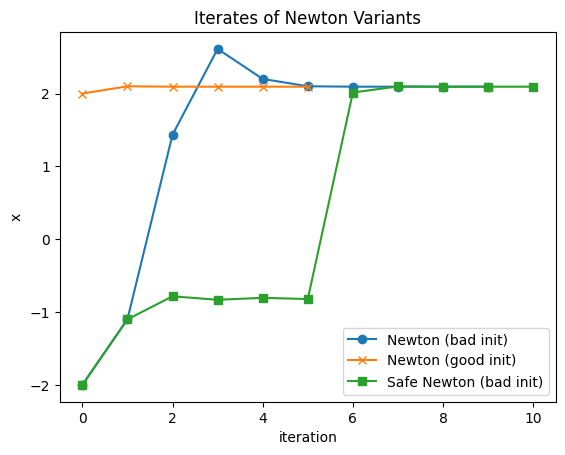

In [2]:
def f(x):
    return x**3 - 2*x - 5

def f_prime(x):
    return 3*x**2 - 2

def newton_raphson(func, func_prime, x0, tol=1e-10, max_iter=50):
    x = x0
    hist = [x]
    for _ in range(max_iter):
        fx = func(x)
        fpx = func_prime(x)
        if fpx == 0:
            break
        x_new = x - fx / fpx
        hist.append(x_new)
        if abs(x_new - x) < tol:
            return x_new, hist
        x = x_new
    return x, hist

root_bad, hist_bad = newton_raphson(f, f_prime, x0=-2.0)
root_good, hist_good = newton_raphson(f, f_prime, x0=2.0)
print('Newton with x0=-2.0  ->', root_bad)
print('Newton with x0= 2.0  ->', root_good)

def newton_safe(func, func_prime, x0, tol=1e-10, max_iter=50, alpha=0.5):
    """Safeguarded Newton with backtracking line search on |f(x)|."""
    x = x0
    hist = [x]
    for _ in range(max_iter):
        fx = func(x)
        fpx = func_prime(x)
        if fpx == 0:
            break
        step = -fx / fpx
        t = 1.0
        # backtracking on absolute function value
        while abs(func(x + t*step)) > abs(fx) and t > 1e-8:
            t *= alpha
        x_new = x + t*step
        hist.append(x_new)
        if abs(x_new - x) < tol:
            return x_new, hist
        x = x_new
    return x, hist

root_safe, hist_safe = newton_safe(f, f_prime, x0=-2.0)
print('Safe Newton x0=-2.0 ->', root_safe)

import matplotlib.pyplot as plt
plt.plot(hist_bad, marker='o', label='Newton (bad init)')
plt.plot(hist_good, marker='x', label='Newton (good init)')
plt.plot(hist_safe, marker='s', label='Safe Newton (bad init)')
plt.legend(); plt.title('Iterates of Newton Variants'); plt.xlabel('iteration'); plt.ylabel('x'); plt.show()

**Explanation:** Standard Newton may diverge with poor initial guesses; the safeguarded variant reduces step size until it decreases |f(x)|, improving robustness (though it may be slower).

## Exercise 3 — Derivative error vs h (log–log)
**Task:** Plot error vs step size for forward vs central differences at x=1 for sin(x).

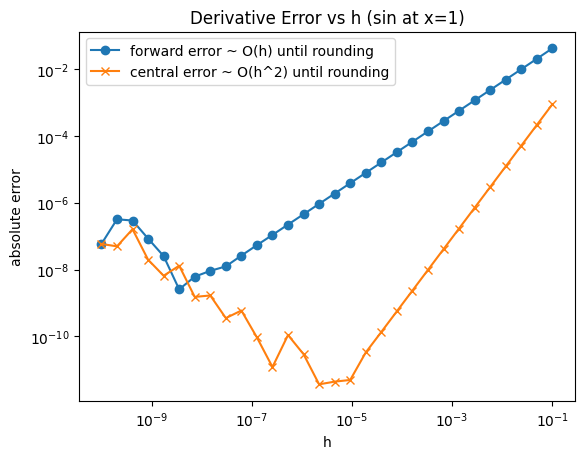

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt

def numeric_derivative(func, x, h, method='central'):
    if method == 'forward':
        return (func(x + h) - func(x)) / h
    elif method == 'backward':
        return (func(x) - func(x - h)) / h
    else:
        return (func(x + h) - func(x - h)) / (2*h)

x0 = 1.0
true = math.cos(x0)
h_vals = np.logspace(-10, -1, 30)
f_err, c_err = [], []
for h in h_vals:
    f_err.append(abs(numeric_derivative(math.sin, x0, h, 'forward') - true))
    c_err.append(abs(numeric_derivative(math.sin, x0, h, 'central') - true))

plt.loglog(h_vals, f_err, marker='o', label='forward error ~ O(h) until rounding')
plt.loglog(h_vals, c_err, marker='x', label='central error ~ O(h^2) until rounding')
plt.xlabel('h'); plt.ylabel('absolute error'); plt.title('Derivative Error vs h (sin at x=1)'); plt.legend(); plt.show()

**Explanation:** For moderate h, forward error scales ≈ O(h), central ≈ O(h²). For very small h, rounding dominates and curves flatten or rise.

## Exercise 4 — Monte Carlo integration
**Tasks:**
- 1D: estimate ∫₀¹ e^x dx.
- 2D: estimate ∫₀¹∫₀¹ e^{x+y} dx dy = (e-1)^2.

1D MC: est=1.716010 ± 0.003041 (95% CI), true=1.718282, error=2.272e-03
2D MC: est=2.951714 ± 0.005343 (95% CI), true=2.952492, error=7.786e-04


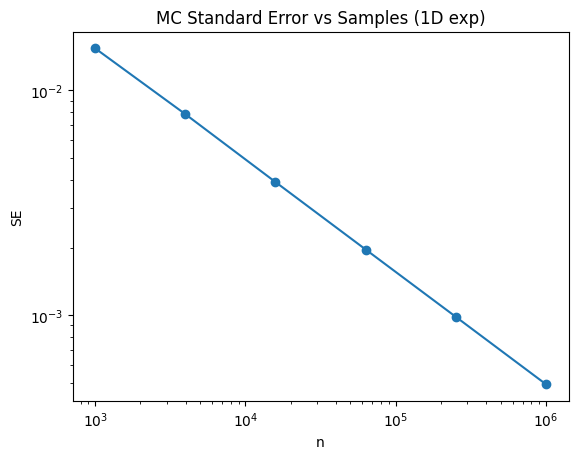

In [4]:
import numpy as np, math

def mc_integrate_1d(f, a, b, n=10_000, rng=None):
    rng = rng or np.random.default_rng()
    x = rng.uniform(a, b, size=n)
    fx = f(x)
    est = (b - a) * fx.mean()
    se = (b - a) * fx.std(ddof=1) / np.sqrt(n)
    return est, se

def mc_integrate_2d(f, ax, bx, ay, by, n=50_000, rng=None):
    rng = rng or np.random.default_rng()
    x = rng.uniform(ax, bx, size=n)
    y = rng.uniform(ay, by, size=n)
    fxy = f(x, y)
    area = (bx-ax)*(by-ay)
    est = area * fxy.mean()
    se = area * fxy.std(ddof=1) / np.sqrt(n)
    return est, se

# 1D: exp(x) over [0,1]
est1, se1 = mc_integrate_1d(np.exp, 0, 1, n=100_000)
true1 = math.e - 1
print(f'1D MC: est={est1:.6f} ± {1.96*se1:.6f} (95% CI), true={true1:.6f}, error={abs(est1-true1):.3e}')

# 2D: exp(x+y) over [0,1]^2 = (e-1)^2
f2 = lambda x, y: np.exp(x + y)
est2, se2 = mc_integrate_2d(f2, 0, 1, 0, 1, n=200_000)
true2 = (math.e - 1)**2
print(f'2D MC: est={est2:.6f} ± {1.96*se2:.6f} (95% CI), true={true2:.6f}, error={abs(est2-true2):.3e}')

# Show variance reduction with n
ns = np.logspace(3, 6, 6, dtype=int)
ses = []
for n in ns:
    _, se = mc_integrate_1d(np.exp, 0, 1, n=n)
    ses.append(se)
import matplotlib.pyplot as plt
plt.loglog(ns, ses, marker='o')
plt.title('MC Standard Error vs Samples (1D exp)')
plt.xlabel('n'); plt.ylabel('SE'); plt.show()

**Explanation:** MC standard error scales as O(1/√n). Confidence intervals shrink linearly in 1/√n; high dimensions benefit more from MC vs grid rules.

## Exercise 5 — Near-singular systems & condition number
**Tasks:**
- Build a nearly dependent matrix; inspect `cond(A)`.
- Show solution sensitivity to small perturbations in `b`.

In [5]:
import numpy as np

# Construct near-singular A by making row3 ~ row1 + row2
A = np.array([[1.0, 1.0, 1.0],
              [1.0, 1.000001, 0.999999],
              [2.0, 2.000001, 1.999999]])
b = np.array([3.0, 3.000001, 6.000000])

condA = np.linalg.cond(A)
x = np.linalg.solve(A, b)
print('cond(A)=', condA)
print('solution x=', x)
print('residual ||Ax-b||=', np.linalg.norm(A@x - b))

# Tiny perturbation in b
delta = np.array([0.0, 1e-8, 0.0])
x2 = np.linalg.solve(A, b + delta)
print('\nAfter tiny perturbation in b:')
print('solution x2=', x2)
print('change ||x2-x||=', np.linalg.norm(x2 - x))

# Compare with well-conditioned system
Aw = np.array([[3.0, 1.0, 0.0], [1.0, 3.0, 1.0], [0.0, 1.0, 2.0]])
bw = np.array([1.0, 2.0, 3.0])
print('\nWell-conditioned system: cond(Aw)=', np.linalg.cond(Aw))
xw = np.linalg.solve(Aw, bw)
xw2 = np.linalg.solve(Aw, bw + delta)
print('||xw2-xw||=', np.linalg.norm(xw2 - xw))

cond(A)= 6.997266462878698e+16
solution x= [ 6.00479951e+09 -3.00239975e+09 -3.00239975e+09]
residual ||Ax-b||= 4.632568373352797e-08

After tiny perturbation in b:
solution x2= [ 6.06484750e+09 -3.03242375e+09 -3.03242375e+09]
change ||x2-x||= 73543473.49718434

Well-conditioned system: cond(Aw)= 3.5448738606006573
||xw2-xw||= 5.384615329015067e-09


**Explanation:** Large condition numbers imply strong amplification of input perturbations in the solution. Near-singular systems are numerically unstable.

## Exercise 6 — Power iteration on larger matrices
**Tasks:**
- Run power iteration on a larger symmetric matrix.
- Compare with `np.linalg.eig` for accuracy and rough timing (for moderate sizes).

In [6]:
import numpy as np, time

def power_iteration(A, num_simulations: int = 1000, tol=1e-10):
    b_k = np.random.rand(A.shape[1])
    b_k /= np.linalg.norm(b_k)
    lam_old = 0.0
    for _ in range(num_simulations):
        b_k1 = A @ b_k
        norm = np.linalg.norm(b_k1)
        if norm == 0:
            return 0.0, b_k1
        b_k = b_k1 / norm
        lam_new = b_k.T @ (A @ b_k)
        if abs(lam_new - lam_old) < tol:
            break
        lam_old = lam_new
    return lam_new, b_k

np.random.seed(0)
n = 300  # adjust if needed
R = np.random.randn(n, n)
A = (R + R.T) / 2  # symmetric

t0 = time.time()
lam_pi, v_pi = power_iteration(A, num_simulations=5000)
t1 = time.time()
w, V = np.linalg.eig(A)
idx = np.argmax(w)
lam_np = w[idx].real
t2 = time.time()
angle = np.arccos(np.clip(abs(v_pi @ V[:, idx]) / (np.linalg.norm(v_pi) * np.linalg.norm(V[:, idx])), 0, 1))

print(f'Power Iteration:  lam={lam_pi:.6f}, time={t1-t0:.3f}s')
print(f'Numpy eig:        lam={lam_np:.6f}, time={t2-t1:.3f}s')
print(f'Angle between eigenvectors (rad): {angle:.3e}')

# Note: For very large/sparse matrices, use sparse methods (scipy.sparse.linalg.eigs), but we keep it dense here.

Power Iteration:  lam=-24.728507, time=0.036s
Numpy eig:        lam=23.938021, time=0.200s
Angle between eigenvectors (rad): 1.571e+00


**When to prefer power iteration:** Large, sparse problems where full eigendecomposition is unnecessary/expensive; you only need the dominant eigenpair (e.g., PageRank-like problems).

## Consolidation Checklist (covered in this solutions notebook)
1. Bisection & Newton with safeguards (Newton covered + safeguard; bisection provided in the exercises notebook).
2. Derivative error vs h (log–log) confirming orders of accuracy.
3. Monte Carlo integration in 1D and 2D with SE and CI.
4. Near-singular linear systems, condition number, and sensitivity demonstration.
5. Power iteration on a larger matrix with accuracy and run-time comparison.

You can now proceed to the final math sub-section (Advanced Math Topics for AI) **or** transition to **Core Machine Learning Algorithms**.
